In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

In [37]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [38]:
print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.validation.images.shape)

print(mnist.train.labels.shape)
print(mnist.test.labels.shape)
print(mnist.validation.labels.shape)
mnist.train.labels[0]

(55000, 784)
(10000, 784)
(5000, 784)
(55000, 10)
(10000, 10)
(5000, 10)


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

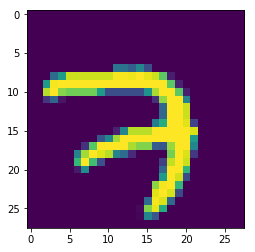

In [39]:
first_image = mnist.train.images[0]
first_image = first_image.reshape(28,28)
plt.imshow(first_image)

In [0]:
# image details
input_width = 28
input_height = 28
input_channels = 1
input_pixels = 784
# CNN layer details
n_conv1 = 32
n_conv2 = 64
stride_conv1 = 1
stride_conv2 = 1
conv1_k = 5
conv2_k = 5
max_pool1_k = 2
max_pool2_k = 2
# hidden layer details
n_hidden = 1024
n_out = 10
input_size_to_hidden = (input_width//(max_pool1_k * max_pool2_k)) * (input_height//(max_pool1_k * max_pool2_k)) * n_conv2

In [0]:
weights = {
    'wc1' : tf.Variable(tf.random_normal([conv1_k,conv1_k,input_channels,n_conv1])),
    'wc2' : tf.Variable(tf.random_normal([conv2_k,conv2_k,n_conv1,n_conv2])),
    'wh1' : tf.Variable(tf.random_normal([input_size_to_hidden,n_hidden])),
    'wo' : tf.Variable(tf.random_normal([n_hidden,n_out]))
}
biases = {
    'bc1' : tf.Variable(tf.random_normal([n_conv1])),
    'bc2' : tf.Variable(tf.random_normal([n_conv2])),
    'bh1' : tf.Variable(tf.random_normal([n_hidden])),
    'bo' : tf.Variable(tf.random_normal([n_out]))
}

In [42]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(3136, 1024) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_8:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_9:0' shape=(3136, 1024) dtype=float32_ref>,
 <tf.Variable 'Variable_10:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_11:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Variable_12:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Variable_13:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Variable_14:0' shape=(10,) dtype=float32_ref>,
 <tf.

In [0]:
# default value of stride is 1
# shape of x and strides(argument) needs to be same(no_img,h,w,channels)
# 1st dont skip the image(1)
# 4th dont move along depth, exactly fit krna h along depth(1)
# 2nd and 3rd -->> k
def conv(x,weights,bias,strides=1):
  # 1) APPLY FILTER
  out = tf.nn.conv2d(x,weights,padding='SAME',strides=[1,strides,strides,1])
  # 2) ADD BIAS
  # use can use 'add' as well but wo different dimensions ke sath nhi khel paega
  out = tf.nn.bias_add(out,bias)
  # 3) APPLY ACTIVATION FUNCTION (IF YOU WANT)
  out = tf.nn.relu(out)
  return out

# default value of k = 2
# ksize similar to strides in conv, we need to tell how to apply max_pooling(no_img,h,w,channels)
# therefore 4 argument (ki channel ke along lagana h ya nhi, g=height kaise kitni leni h)
# we need to tell how to move also
# therefore we pass strides along with 4 arguemnt
def maxpooling(x , k = 2):
  return tf.nn.max_pool(x,padding='SAME', ksize = [1,k,k,1] , strides = [1,k,k,1])

In [0]:
def cnn(x,weights,biases):
  # we want to reshape to image of 3D(28 * 28 * 1)
  # -1 -->> figures out 4th argument on its own
  x = tf.reshape(x,shape = [-1,input_height,input_width,input_channels])
  
  # pass through convolution layer 1
  conv1 = conv(x,weights['wc1'],biases['bc1'],stride_conv1)
  conv1_pool = maxpooling(conv1,max_pool1_k)
  
  # pass through convolution layer 2
  conv2 = conv(conv1_pool,weights['wc2'],biases['bc2'],stride_conv2)
  conv2_pool = maxpooling(conv2,max_pool2_k)
  
  # now we need to flatten it(2nd max se jo nikalega pehle calculate krliya tha)
  hidden_input = tf.reshape(conv2_pool,shape = [-1,input_size_to_hidden])
  
  # pass through dense layer
  hidden_output_before_activation = tf.add(tf.matmul(hidden_input,weights['wh1']),biases['bh1'])
  hidden_output = tf.nn.relu(hidden_output_before_activation)
  
  
  # no activation function
  output_layer = tf.add(tf.matmul(hidden_output,weights['wo']), biases['bo'])
  return output_layer

In [0]:
x = tf.placeholder(tf.float32,[None, input_pixels])
y = tf.placeholder(tf.int32,[None,n_out])
pred = cnn(x,weights,biases)

In [0]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred,labels = y))

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate = 0.01)
optimize = optimizer.minimize(cost)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#c,_ = sess.run([cost,optimize],feed_dict={
#    x : mnist.train.images,
#    y : mnist.train.labels
#})
#c

In [49]:
batch_size = 100
for i in range(25):
    num_batches = int(mnist.train.num_examples/batch_size)
    total_cost = 0
    for j in range(num_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        c, _ = sess.run([cost,optimize], feed_dict={x:batch_x , y:batch_y})
        total_cost += c
    print(total_cost)

1129390.724961996
32049.271520761118
15691.798953425174
11097.63744650704
9939.537302054465
9233.726069002309
10280.294749536515
7925.6130662709475
6607.888026516885
7185.230815703406
7179.518764375942
6513.947763477233
4503.731624864935
5872.00694765538
4155.979861850792
3227.9587738585055
3825.3740861321558
3472.797331575912
3281.291742639921
2386.9038850883844
2232.4888155738413
3185.074781431119
2149.233286399797
1681.4339247538037
3151.1878714215945


In [50]:
predictions = tf.argmax(pred,1)
actual = tf.argmax(y,1)

score = tf.equal(predictions,actual)

predictions,score = sess.run([predictions,score],feed_dict = {
    x : mnist.test.images,
    y : mnist.test.labels
})
predictions,actual,score.sum()

(array([7, 2, 1, ..., 4, 5, 6]),
 <tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>,
 9853)

In [0]:
## ADDING DROPOUT LAYER
# pass keep probablity : probability with which we keep and element
def cnn(x,weights,biases,keep_prob):
  # we want to reshape to image of 3D(28 * 28 * 1)
  # -1 -->> figures out 4th argument on its own
  x = tf.reshape(x,shape = [-1,input_height,input_width,input_channels])
  
  # pass through convolution layer 1
  conv1 = conv(x,weights['wc1'],biases['bc1'],stride_conv1)
  conv1_pool = maxpooling(conv1,max_pool1_k)
  
  # pass through convolution layer 2
  conv2 = conv(conv1_pool,weights['wc2'],biases['bc2'],stride_conv2)
  conv2_pool = maxpooling(conv2,max_pool2_k)
  
  # now we need to flatten it(2nd max se jo nikalega pehle calculate krliya tha)
  hidden_input = tf.reshape(conv2_pool,shape = [-1,input_size_to_hidden])
  
  # pass through dense layer
  ######## CHANGE ##########
  hidden_output_before_activation = tf.add(tf.matmul(hidden_input,weights['wh1']),biases['bh1'])
  hidden_out_before_dropout = tf.nn.relu(hidden_output_before_activation)
  hidden_output = tf.nn.dropout(hidden_out_before_dropout,keep_prob)
  ####### CHANGE OVER! #########
  
  # no activation function
  output_layer = tf.add(tf.matmul(hidden_output,weights['wo']), biases['bo'])
  return output_layer

In [0]:
x = tf.placeholder(tf.float32,[None, input_pixels])
y = tf.placeholder(tf.int32,[None,n_out])
####### CHANGE #######
keep_prob = tf.placeholder('float')
####### CHANGE OVER! #######
pred = cnn(x,weights,biases,keep_prob)

In [0]:
#cost code
#optimizer code
#session code

batch_size = 100
for i in range(25):
    num_batches = int(mnist.train.num_examples/batch_size)
    total_cost = 0
    for j in range(num_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        ####### CHANGE #######
        c, _ = sess.run([cost,optimize], feed_dict={x:batch_x , y:batch_y, keep_prob : 1.0})
        ####### CHANGE OVER! ######
        total_cost += c
    print(total_cost)
    
# keep_prob = 1 that means we want to keep everything, we arent if ignoring anything in case of training

In [0]:
predictions = tf.argmax(pred,1)
actual = tf.argmax(y,1)

score = tf.equal(predictions,actual)

predictions,score = sess.run([predictions,score],feed_dict = {
    x : mnist.test.images,
    y : mnist.test.labels,
    keep_prob : 0.8
})
predictions,actual,score.sum()